# Support Vector Machines

In [1]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST





## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

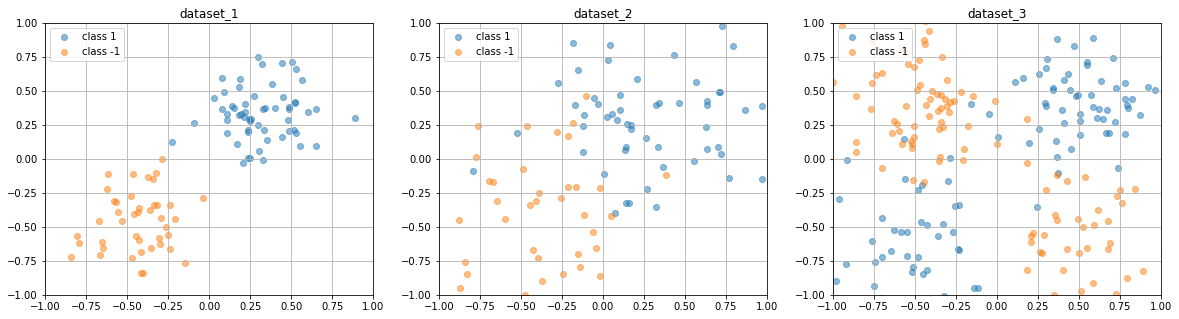

In [2]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
fig, ax = plt.subplots(1,3, figsize=(20, 5))
for i, (name, dataset) in enumerate(datasets.items()):
    
    plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax[i])
    ax[i].set_title(name)


## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [4]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
        self.name = 'RBF'
    def kernel(self,X,Y):
        squared_norm = np.expand_dims(np.sum(X**2,axis=1),axis=1) + np.expand_dims(np.sum(Y**2,axis=1),axis=0)-2*np.einsum('ni,mi->nm',X,Y)
        return np.exp(-0.5*squared_norm/self.sigma**2)
class Linear:
    def __init__(self):
        self.name= 'linear'
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return np.einsum('nd,md->nm',X,Y)
    


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [7]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        hXX = self.kernel(X, X)
        G = np.einsum('ij,i,j->ij',hXX,y,y)
        A = np.vstack((-np.eye(N), np.eye(N)))             
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  

        # Lagrange dual problem
        def loss(alpha):
            return -alpha.sum() + 0.5 * alpha.dot(alpha.dot(G))  #'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return -np.ones_like(alpha) + alpha.dot(G) # '''----------------partial derivative of the dual loss wrt alpha-----------------'''


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha:  np.dot(alpha, y) # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:   y  #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha:  b - np.dot(A, alpha) # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha:  -A # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes
        
        margin_pointsIndices = (self.alpha > self.epsilon)
        boundaryIndices = (self.alpha > self.epsilon) * (self.C- self.alpha > self.epsilon )
        
        self.support = X[boundaryIndices] #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        
        self.margin_points = X[margin_pointsIndices]
        self.margin_points_AlphaY = y[margin_pointsIndices] * self.alpha[margin_pointsIndices]
        
        self.b = y[boundaryIndices][0] - self.separating_function(np.expand_dims(X[boundaryIndices][0],axis=0)) #''' -----------------offset of the linear classifier------------------ '''
        K_margin_points = self.kernel(self.margin_points, self.margin_points)
        self.norm_f = np.einsum('i,ij,j->', self.margin_points_AlphaY , K_margin_points, self.margin_points_AlphaY)


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        x1 = self.kernel(self.margin_points, x)
        return np.einsum('ij,i->j',x1,self.margin_points_AlphaY)
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

### 2- Fitting the classifier

Run the code block below to fit the classifier and report its output.

Number of support vectors = 2
Number of support vectors = 3
Number of support vectors = 8


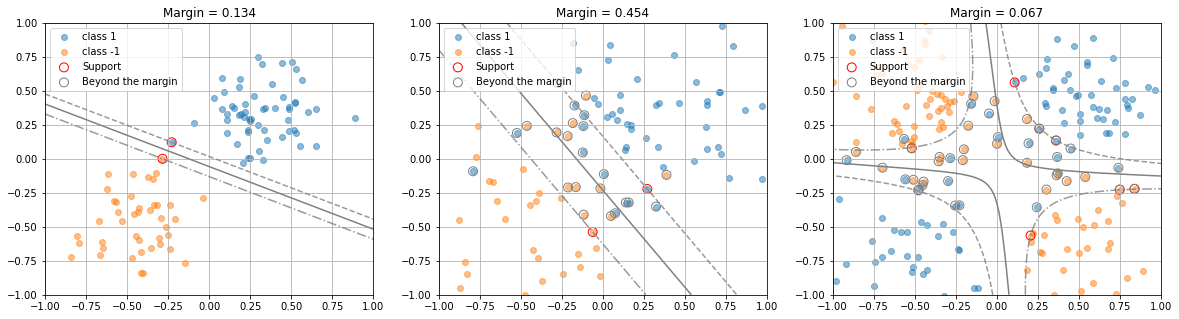

In [6]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
C = 10000.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[0])

C = 10.
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[1])


sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax=ax[2])


# Kernel Regression

## Loading the data

In [8]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])


## Kernel  Support Vector Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 


In [9]:
class KernelSVR:
    
    def __init__(self, C, kernel, eta= 1e-2, epsilon = 1e-3):
        self.C = C                               
        self.kernel = kernel  
        self.alpha = None # Vector of size 2*N
        self.support = None
        self.eta = eta
        self.epsilon = epsilon
        self.eps = 0.
        self.type='svr'
        
    def fit(self, X, y):
        
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        G = self.kernel(X, X)
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        A = np.vstack((np.hstack((A,np.zeros_like(A))),np.hstack((np.zeros_like(A),A)) ))
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        b = np.hstack((b,b))
        # <---

        # Lagrange dual problem
        def loss(alpha):
            diff = alpha[:N]-alpha[N:] 
            return  0.5 * np.einsum('i,ij,j->',diff,G,diff) +0.5 *self.eps*np.sum(alpha**2) + self.eta*np.sum(alpha)- np.einsum('i,i->',y,diff) #'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            diff = alpha[:N]-alpha[N:]
            Gdiff = np.einsum('ij,j->i',G,diff)
            grad = Gdiff - y
            return np.hstack((grad,-grad)) + self.eps*alpha +self.eta*np.ones_like(alpha)
            
        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        fun_eq = lambda alpha:  np.sum(alpha[:N]-alpha[N:]) # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:   np.hstack((np.ones(N), -np.ones(N)))   #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha:  b - np.einsum('ij,j->i',A,alpha) # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha:  -A # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 'fun': fun_ineq , 'jac': jac_ineq})
        
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0= self.C*np.ones(2*N),
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints, 
                                   tol=1e-7)
        self.alpha = optRes.x

        ## Assign the required attributes
 
        marginIndices_1 = (self.alpha[:N] > self.epsilon)
        marginIndices_2 = (self.alpha[N:] > self.epsilon)
        marginIndices = marginIndices_1  +marginIndices_2
        
        self.boundaryIndices_1 = (self.alpha[:N] > self.epsilon) * (self.C- self.alpha[:N] > self.epsilon )
        self.boundaryIndices_2 = (self.alpha[N:] > self.epsilon) * (self.C- self.alpha[N:] > self.epsilon )
        boundaryIndices = self.boundaryIndices_1+self.boundaryIndices_2
        self.support = np.concatenate([X[boundaryIndices],np.expand_dims(y[boundaryIndices], axis=1)], axis=1) #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        self.margin_points = X[marginIndices]
        diff = self.alpha[:N]-self.alpha[N:]
        self.margin_pointsAlphadiff = diff[marginIndices]
        boundary_pos = np.max(y[self.boundaryIndices_1] - self.regression_function(X[self.boundaryIndices_1]))
        boundary_neg = np.min(y[self.boundaryIndices_2] - self.regression_function(X[self.boundaryIndices_2]))
        self.b = 0.5*(boundary_pos + boundary_neg)    #''' -----------------offset of the linear classifier------------------ '''

   ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        x1 = self.kernel(self.margin_points , x)
        return np.einsum('ij,i->j',x1,self.margin_pointsAlphadiff)
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X)+self.b
    

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

Number of support vectors = 18


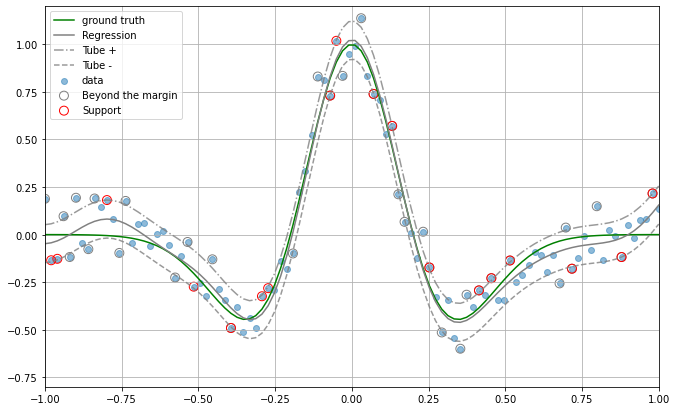

In [10]:
sigma = 0.2
C = 10.
kernel = RBF(sigma).kernel
model = KernelSVR(C,kernel, eta= .1, epsilon = 1e-6)
model.fit(train_set['x'].reshape(-1,1),train_set['y'])
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')